In [85]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
import plotly.express as px
import numpy as np
import pandas as pd
import re

In [22]:
model_names = {
    "deberta": "deepset/deberta-v3-large-squad2",
    "bert_large_deepset": "deepset/bert-large-uncased-whole-word-masking-squad2",
    "bert_base": "deepset/bert-base-cased-squad2",
}

models = {}
for model_name in model_names:
    models[model_name] = pipeline("question-answering", model=model_names[model_name], tokenizer=model_names[model_name])

# Importing the data

In [23]:
df = pd.read_excel('./data/Example forms.xlsx', sheet_name='Lunch_Extractive', dtype=str)

df_melted = df.melt(id_vars='Full story', var_name='question', value_name='answer')
df_melted.columns = ['context', 'question', 'answer']
# replace '?' with '' in answer
df_melted['answer'] = df_melted['answer'].str.replace('?', '')
df = df_melted

C:\Users\elibr\AppData\Local\Temp\ipykernel_9488\146949446.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_melted['answer'] = df_melted['answer'].str.replace('?', '')


In [24]:
# Run questions through models
def generate_predictions(models, dataset):
    results = pd.DataFrame()
    index = 0
    for model in models:
        for row in dataset.iterrows():
            prediction = models[model](context=row[1]['context'], question=row[1]['question'])
            new_row = pd.DataFrame({
                'context': row[1]['context'], 
                'question': row[1]['question'], 
                'answer': row[1]['answer'], 
                'model': model, 
                'prediction': prediction['answer'], 
                'model_confidence': prediction['score']
            }, index=[index])
            results = pd.concat([results, new_row])
            index += 1
    return results

In [25]:
similarity_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
def average_answer(dataset): # only answers for a single question
    # get all embeddings from similarity model
    vector_embeddings = {}
    for index, row in dataset.iterrows():
        model_name = row['model']
        vector_embeddings[model_name] = similarity_model.encode(row["prediction"])
    # calculate average vector
    average_vector = np.average(list(vector_embeddings.values()), axis=0)

    # Return answer closest to average
    closest_to_average = max(vector_embeddings, key=lambda key: util.pytorch_cos_sim(average_vector, vector_embeddings[key]))
    row_closest_to_average = dataset[dataset['model'] == closest_to_average]
    return row_closest_to_average

questions = df['question'].unique()
contexts = df['context'].unique()

In [26]:
# answers = generate_predictions(models, df_melted)

In [27]:
# # for each question, get the average answer
# average_answers = pd.DataFrame()
# for question in questions:
#     average_answers = pd.concat([average_answers, average_answer(answers[answers['question'] == question])])

# # count per model
# count_per_model = average_answers.groupby('model').count()
# count_per_model

In [28]:
def answer_form(context, question, expected_answer, models):
    return_data = pd.DataFrame({"context": [context], "question": [question], "expected_answer": [expected_answer]})
    # get answer from each model
    answers = generate_predictions(models, pd.DataFrame({'context': [context], 'question': [question], 'answer': [expected_answer]}))
    # get embedding for each answer
    vector_embeddings = {}
    for index, row in answers.iterrows():
        model_name = row['model']
        vector_embeddings[model_name] = similarity_model.encode(row["prediction"])
    
    # get average answer
    var_average_answer = average_answer(answers)
    return_data['average_answer'] = var_average_answer['prediction'].values[0]
    average_answer_model = var_average_answer['model'].values[0]
    return_data['average_answer_model'] = average_answer_model

    #
    # Metrics
    #

    # final answer distance to average
    average_vector = np.average(list(vector_embeddings.values()), axis=0)
    return_data['final_answer_distance_to_average'] = util.pytorch_cos_sim(average_vector, vector_embeddings[average_answer_model]).item()
    
    # mean all distances to average
    return_data['mean_all_distances_to_average'] = np.mean([util.pytorch_cos_sim(average_vector, vector_embeddings[model]).item() for model in vector_embeddings]).item()

    # mean distance between all answers
    return_data['mean_distance_between_all_answers'] = np.mean([util.pytorch_cos_sim(vector_embeddings[model1], vector_embeddings[model2]).item() for model1 in vector_embeddings for model2 in vector_embeddings if model1 != model2]).item()

    # mean confidence
    return_data['mean_confidence'] = np.mean([row['model_confidence'] for index, row in answers.iterrows()]).item()

    # confidence of final answer
    return_data['confidence_of_final_answer'] = answers[answers['model'] == average_answer_model]['model_confidence'].values[0]
    
    # count of models that returned the same answer
    return_data['count_of_models_that_returned_the_same_answer'] = len(answers[answers['prediction'] == return_data['average_answer'].values[0]])
    

    #
    # Target: similarity of final answer to expected answer
    #
    return_data['similarity_of_final_answer_to_expected_answer'] = util.pytorch_cos_sim(similarity_model.encode(return_data['average_answer'].values[0]), similarity_model.encode(return_data['expected_answer'].values[0])).item()
    
    return return_data

df_all_metrics = pd.DataFrame()
for context in contexts:
    for question in questions:
        df_all_metrics = pd.concat([df_all_metrics, answer_form(context, question, df.loc[(df['context'] == context) & (df['question'] == question), 'answer'].values[0], models)])

df_all_metrics.head()

,context,question,expected_answer,average_answer,average_answer_model,final_answer_distance_to_average,mean_all_distances_to_average,mean_distance_between_all_answers,mean_confidence,confidence_of_final_answer,count_of_models_that_returned_the_same_answer,similarity_of_final_answer_to_expected_answer
0,I would like to arrange a lunch on March 24 in...,How many people are coming?,25 to 30,25 to 30,deberta,0.983956,0.967362,0.903685,0.422513,3.808479e-01,1,1.000000
0,I would like to arrange a lunch on March 24 in...,Who is the organizer?,,25 to 30,bert_base,0.623744,0.617268,0.071530,0.017748,1.690518e-03,1,0.010297
0,I would like to arrange a lunch on March 24 in...,What is the budget?,,25 to 30,deberta,0.903877,0.775137,0.401256,0.059899,1.276783e-07,1,0.010297
0,I would like to arrange a lunch on March 24 in...,What is the date?,March 24,March 24,deberta,1.000000,1.000000,1.000000,0.891966,9.884323e-01,1,1.000000
0,I would like to arrange a lunch on March 24 in...,What is the start time?,12:30,12:30,bert_large_deepset,0.996271,0.992514,0.977627,0.750143,8.131435e-01,2,1.000000


In [93]:
load_from_file = False
if load_from_file:
    df_all_metrics = pd.read_csv('df_all_metrics.csv')
    # set empty expected answers to empty string
    df_all_metrics['expected_answer'] = df_all_metrics['expected_answer'].fillna('')

# Define a function to clean the answers (remove all but the letters and numbers, and convert to lowercase)
def clean_answer(answer):
    regex = re.compile('[^a-zA-Z0-9]')
    answer = regex.sub('', answer)
    answer = answer.lower()
    return answer

# Clean the expected_answer and average_answer columns
df_all_metrics['clean_expected_answer'] = df_all_metrics['expected_answer'].apply(clean_answer)
df_all_metrics['clean_average_answer'] = df_all_metrics['average_answer'].apply(clean_answer)

# Create a new column to store the final answer (use_final_answer)
df_all_metrics['use_final_answer'] = np.nan

# Set the value of use_final_answer based on whether the clean_expected_answer and clean_average_answer match
df_all_metrics.loc[df_all_metrics['clean_expected_answer'] == df_all_metrics['clean_average_answer'], 'use_final_answer'] = True

# Set the value of use_final_answer to False for any rows where expected_answer is blank
df_all_metrics.loc[df_all_metrics['expected_answer'] == '', 'use_final_answer'] = False

# For any remaining rows where use_final_answer is still NaN, prompt the user for input
null_rows = df_all_metrics[df_all_metrics['use_final_answer'].isnull()]
num_remaining = len(null_rows)

def prompt_user(row):
    use_final_answer = input(f"Context: {row['context']}, question: {row['question']}, final answer: {row['average_answer']}, expected answer: {row['expected_answer']}, use final answer? (y/n)")
    if use_final_answer.lower() == 'y':
        return True
    else:
        return False

df_all_metrics.loc[df_all_metrics['use_final_answer'].isnull(), 'use_final_answer'] = null_rows.apply(prompt_user, axis=1)

# Remove the clean_expected_answer and clean_average_answer columns
df_all_metrics.drop(['clean_expected_answer', 'clean_average_answer'], axis=1, inplace=True)

# save to csv
df_all_metrics.to_csv('df_all_metrics.csv', index=False)
  

In [97]:
# print ratio of final answers used
print(f"Final answers used: {df_all_metrics['use_final_answer'].sum() / len(df_all_metrics)}")

Final answers used: 0.6805555555555556


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df_all_metrics[['final_answer_distance_to_average', 'mean_all_distances_to_average', 'mean_distance_between_all_answers', 'mean_confidence', 'confidence_of_final_answer', 'count_of_models_that_returned_the_same_answer']]
y = df_all_metrics['use_final_answer']
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8


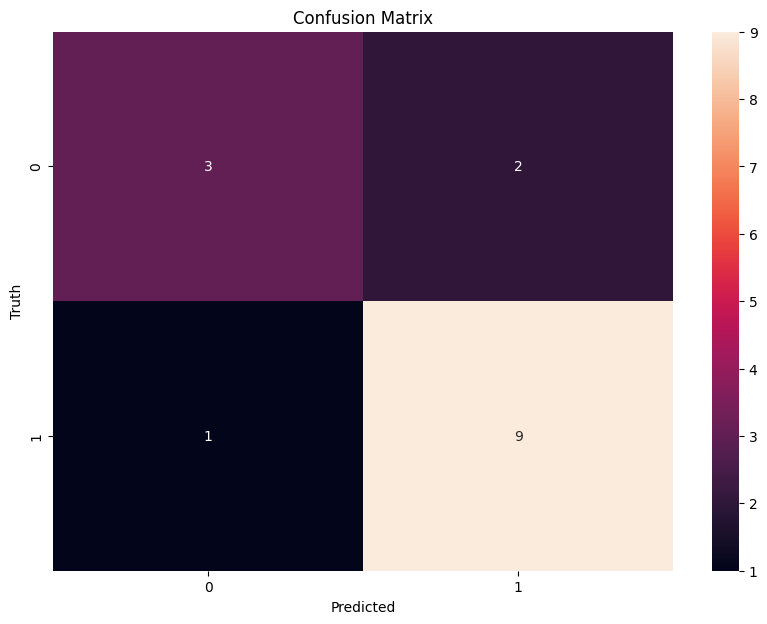

In [114]:
# seaborn confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()